In [20]:
import gc
import math
from time import time_ns
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import numba as nb
from numba import cuda  # must be explicitly imported
from tqdm import tqdm

if False:  # numba unhappy when used with target=cuda
    sin = np.sin
    cos = np.cos
else:
    sin = math.sin
    cos = math.cos

In [2]:
def base_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(round(scalar)):
        for jdx in range(round(scalar / 2)):
            if idx % 2 == 0:
                if jdx % 2 == 0:
                    res += sin(idx) * sin(jdx)
                else:
                    res += sin(idx) * cos(jdx)
            else:
                if jdx % 2 == 0:
                    res -= cos(idx) * sin(jdx)
                else:
                    res -= cos(idx) * cos(jdx)
    return res

def base(d: np.ndarray) -> np.ndarray:
    r = np.zeros(d.shape, dtype = d.dtype)
    for idx in range(d.shape[0]):
        r[idx] = base_dummy(d[idx])
    return r

In [3]:
@nb.njit
def njited_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(round(scalar)):
        for jdx in range(round(scalar / 2)):
            if idx % 2 == 0:
                if jdx % 2 == 0:
                    res += sin(idx) * sin(jdx)
                else:
                    res += sin(idx) * cos(jdx)
            else:
                if jdx % 2 == 0:
                    res -= cos(idx) * sin(jdx)
                else:
                    res -= cos(idx) * cos(jdx)
    return res

@nb.njit
def njited(d: np.ndarray) -> np.ndarray:
    r = np.zeros(d.shape, dtype = d.dtype)
    for idx in range(d.shape[0]):
        r[idx] = njited_dummy(d[idx])
    return r

In [4]:
@nb.njit(inline = 'always')
def njited_inline_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(round(scalar)):
        for jdx in range(round(scalar / 2)):
            if idx % 2 == 0:
                if jdx % 2 == 0:
                    res += sin(idx) * sin(jdx)
                else:
                    res += sin(idx) * cos(jdx)
            else:
                if jdx % 2 == 0:
                    res -= cos(idx) * sin(jdx)
                else:
                    res -= cos(idx) * cos(jdx)
    return res

@nb.njit
def njited_inline(d: np.ndarray) -> np.ndarray:
    r = np.zeros(d.shape, dtype = d.dtype)
    for idx in range(d.shape[0]):
        r[idx] = njited_inline_dummy(d[idx])
    return r

In [5]:
@nb.njit
def njited_parallel_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(round(scalar)):
        for jdx in range(round(scalar / 2)):
            if idx % 2 == 0:
                if jdx % 2 == 0:
                    res += sin(idx) * sin(jdx)
                else:
                    res += sin(idx) * cos(jdx)
            else:
                if jdx % 2 == 0:
                    res -= cos(idx) * sin(jdx)
                else:
                    res -= cos(idx) * cos(jdx)
    return res

@nb.njit(parallel = True)
def njited_parallel(d: np.ndarray) -> np.ndarray:
    r = np.zeros(d.shape, dtype = d.dtype)
    for idx in nb.prange(d.shape[0]):
        r[idx] = njited_parallel_dummy(d[idx])
    return r

In [6]:
@nb.njit
def vectorized_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(round(scalar)):
        for jdx in range(round(scalar / 2)):
            if idx % 2 == 0:
                if jdx % 2 == 0:
                    res += sin(idx) * sin(jdx)
                else:
                    res += sin(idx) * cos(jdx)
            else:
                if jdx % 2 == 0:
                    res -= cos(idx) * sin(jdx)
                else:
                    res -= cos(idx) * cos(jdx)
    return res

@nb.vectorize
def vectorized(d: float) -> float:
    return vectorized_dummy(d)

In [7]:
@nb.njit('f8(f8)')
def vectorized_parallel_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(round(scalar)):
        for jdx in range(round(scalar / 2)):
            if idx % 2 == 0:
                if jdx % 2 == 0:
                    res += sin(idx) * sin(jdx)
                else:
                    res += sin(idx) * cos(jdx)
            else:
                if jdx % 2 == 0:
                    res -= cos(idx) * sin(jdx)
                else:
                    res -= cos(idx) * cos(jdx)
    return res

@nb.vectorize('f8(f8)', target = 'parallel')
def vectorized_parallel(d: float) -> float:
    return vectorized_parallel_dummy(d)

In [8]:
# @nb.njit('f8(f8)') -> Untyped global name 'vectorized_cuda_dummy': using cpu function on device but its compilation is disabled
# @nb.vectorize('f8(f8)', target = 'cuda') > Untyped global name 'vectorized_cuda_dummy': Cannot determine Numba type of <class 'numba.cuda.dispatcher.CUDAUFuncDispatcher'>
@cuda.jit('f8(f8)', device = True, inline = True)
def vectorized_cuda_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(round(scalar)):
        for jdx in range(round(scalar / 2)):
            if idx % 2 == 0:
                if jdx % 2 == 0:
                    res += sin(idx) * sin(jdx)
                else:
                    res += sin(idx) * cos(jdx)
            else:
                if jdx % 2 == 0:
                    res -= cos(idx) * sin(jdx)
                else:
                    res -= cos(idx) * cos(jdx)
    return res

@nb.vectorize('f8(f8)', target = 'cuda')
def vectorized_cuda(d: float) -> float:
    return vectorized_cuda_dummy(d)

In [9]:
funcs = [
    base,
    njited,
    njited_inline,
    njited_parallel,
    vectorized,
    vectorized_parallel,
    vectorized_cuda,
]

In [10]:
def test_all(size = 100):
    
    data = np.random.random(size) * 128
    res_base = funcs[0](data)
    
    for func in funcs[1:]:
        res = func(data)
        assert np.allclose(res_base, res)
        
test_all()

/home/ernst/Desktop/PROJEKTE/prj.TST2/github.poliastro/env310/lib/python3.10/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (128) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [11]:
def _name(func):
    try:
        return func.__name__
    except AttributeError:  # numba#8272
        return list(func.functions.values())[0][1].py_func.__name__[13:]

def benchmark(start = 4, stop = 20, reps = 5):
    sizes = (2 ** np.arange(start, stop + 0.5, 0.5)).astype('i8')
    results = {_name(func): [] for func in funcs[1:]}
    gc.disable()
    for size in tqdm(sizes):
        data = np.random.random(size) * 100
        for func in funcs[1:]:  # exclude pure python
            runtimes = []
            for rep in range(reps):
                gc.collect()
                start = time_ns()
                _ = func(data)
                runtime = time_ns() - start
                runtimes.append(runtime)
            results[_name(func)].append(min(runtimes) * 1e-9)
    gc.enable()
    return sizes, results

s, r = benchmark()

 33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                            | 11/33 [00:16<00:37,  1.69s/it]/home/ernst/Desktop/PROJEKTE/prj.TST2/github.poliastro/env310/lib/python3.10/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (2) < 2 * SM count (128) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   

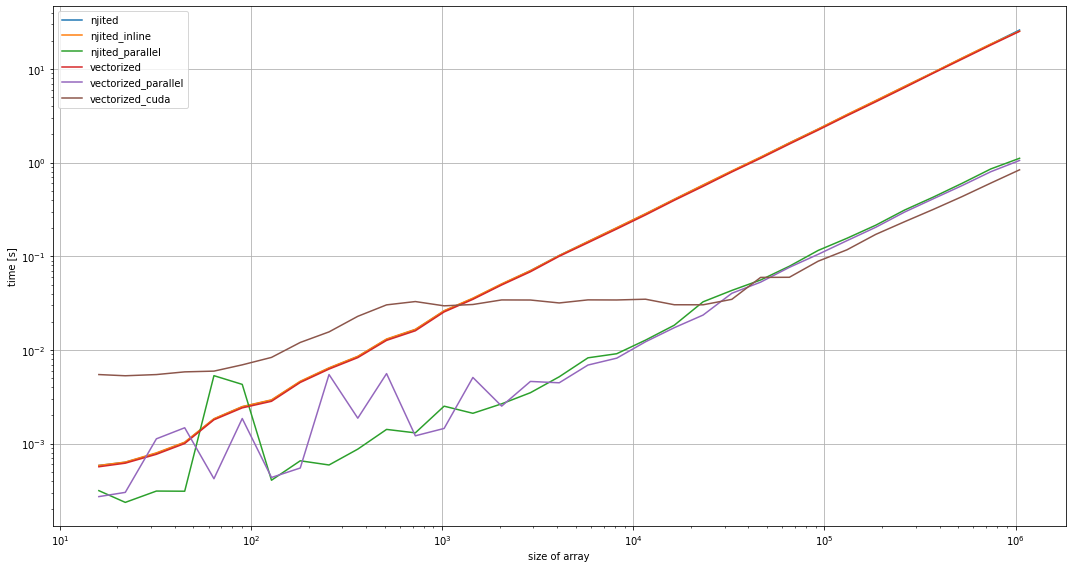

In [12]:
def plot(sizes, results):
    fig, ax = plt.subplots(figsize = (15, 8))
    for name, values in results.items():
        ax.loglog(sizes, values, label = name)
    ax.legend()
    ax.set_xlabel('size of array')
    ax.set_ylabel('time [s]')
    ax.grid()
    fig.tight_layout()

plot(s, r)

In [14]:
s

array([     16,      22,      32,      45,      64,      90,     128,
           181,     256,     362,     512,     724,    1024,    1448,
          2048,    2896,    4096,    5792,    8192,   11585,   16384,
         23170,   32768,   46340,   65536,   92681,  131072,  185363,
        262144,  370727,  524288,  741455, 1048576])

In [21]:
pprint(r)

{'njited': [0.0005852520000000001,
            0.000633172,
            0.000788583,
            0.001030054,
            0.001834516,
            0.0024764490000000004,
            0.002912711,
            0.0045884160000000005,
            0.006403814000000001,
            0.008506292,
            0.012985829,
            0.016501522,
            0.026102388,
            0.035455133,
            0.050414698,
            0.07022255300000001,
            0.102141753,
            0.143477148,
            0.20106863300000002,
            0.283763772,
            0.40557058700000004,
            0.573588455,
            0.810370942,
            1.138261439,
            1.623182863,
            2.281308476,
            3.237268932,
            4.56526542,
            6.476933603,
            9.156464757,
            13.018211255,
            18.396063794,
            26.089697106000003],
 'njited_inline': [0.000585522,
                   0.0006359930000000001,
                   0.00079813